<h1 align="center">P2: Analyzing the NYC Subway Dataset</h1>

<h2>Section 0. References</h2>

<a href=https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test>Mann Whitney U test, Wikipedia</a><br>
<a href=https://en.wikipedia.org/wiki/Tourism_in_New_York_City>Tourism in New York City, Wikipedia</a><br>
<a href=http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit>The Minitab Blog</a><br>
<a href=http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html>Stochastic Gradient Descent: SGDRegressor</a><br>

<h3>Preface</h3>
In this report, I uesd the second verison of data to do analysis.

In [1]:
#Import required modules
import pandas as pd
import numpy as np
import scipy as sc
from scipy import stats as st

#keep the plot in the same windows
%pylab inline
from matplotlib import pyplot as plt
from matplotlib import gridspec as gc


#read the required data for the following contents.
path = r'./dataSet/turnstile_weather_v2.csv'
dF = pd.read_csv(path)

Populating the interactive namespace from numpy and matplotlib


<h2>Section 1. Statistical Test</h2>

<h4>
1.1 Which statistical test did you use to analyze the NYC subway data? Did you use a one-tail or a two-tail P value? What is the null hypothesis? What is your p-critical value?
</h4>

<p>
I used <strong>Mann-Whitney U Test</strong> to analyze the NYC subway data. I decided to use <strong>two-tail</strong> P value after I checked the distributions of the data sets (shown in section 3). Although It was obviously that the size of non rainy days was much more than the size of rainy days. , it was hard to know that the rideship was getting more in the rainy days or not.<br>
The hypothesis is set as follows:<br>
H<sub>0</sub>: The distribution of number of entires is statistically <strong>the same</strong> between rainy days and non rainy days.<br>
H<sub>1</sub>: The distribution of number of entires is statistically <strong>different</strong> between rainy days and non rainy days.<br>
And the p-critical value is <strong>0.05</strong>.
</p>

<h4>
1.2 Why is this statistical test applicable to the dataset? In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.
</h4>

<p>
1. It is obvious that histogram plots of both rainy days and non rainy days are not normal distribution.<br>
2. The indenpdent variable which consist of two categorical, independent groups, rainy days and non rainy days.<br>
3. The samples were ordinal. And they were the observations.<br>
4. Both sample sizes of rainy days and non rainy days were unequal.<br>
5. the sample size of the non rainy days was much larger than that of the rainy days.  
</p>

<h4>1.3 What results did you get from this statistical test? These should include the following numerical values: p-values, as well as the means for each of the two samples under test.
</h4>

In [2]:
def mann_whitney_u_test(dF):
  
    yRain = dF['ENTRIESn_hourly'][dF['rain'] == 1] # non rain day
    nRain = dF['ENTRIESn_hourly'][dF['rain'] == 0] # rainy day

    meanYR = np.mean(yRain)
    meanNR = np.mean(nRain)


    U, p = st.mannwhitneyu(yRain.tolist(), nRain.tolist())
    return meanNR, meanYR, U, p

meanNR, meanYR, U, p = mann_whitney_u_test(dF)
print "the mean of rainy days' data is ", meanYR
print "the mean of non rainy days' data is ", meanNR
print "the Mann Whitney U test is ", U
print "the p-value is ", p*2


the mean of rainy days' data is  2028.19603547
the mean of non rainy days' data is  1845.53943866
the Mann Whitney U test is  153635120.5
the p-value is  5.48213914249e-06


<h4>
1.4 What is the significance and interpretation of these results?
</h4>

<p>
As results shown in 1.3, p-value was 5.48&#215;10<sup>-6</sup> which was much less than critical-p value, 0.05. So that it was statistically significant different in the distribution of number of entries between the rainy days and the non rainy days. Thus the conclusion was to reject null hypothesis. 
</p>

<h2>Section 2. Linear Regression</h2>

<h4>
2.1 What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model:<br>
a. OLS using Statsmodels or Scikit Learn<br>
b. Gradient descent using Scikit Learn<br>
c. Or something different?<br>
</h4>

<p>
In this section, I performed the results of the linear regression with both a. OLS using Statsmodels and b. Gradient descent using Sckit Learn.<br>
The programs I used to do the linear regression were shown as follows.
</p>

In [3]:
def getAnalysisData(dF):
    #Features
    features = dF[['rain']]
    dummy_units = pd.get_dummies(dF['UNIT'], prefix='unit')
    dummy_hour = pd.get_dummies(dF['hour'], prefix='hour')
    dummy_daywk = pd.get_dummies(dF['day_week'], prefix='day_week')
    features = features.join(dummy_units).join(dummy_hour).join(dummy_daywk)
    #Values
    values = dF['ENTRIESn_hourly']
    return features, values

In [4]:
from sklearn.linear_model import SGDRegressor as sg

def normalize_feature_sk(features):
    means = np.mean(features, axis=0)
    std_devs = np.std(features, axis=0)
    normalized_features = (features - means)/std_devs
    return means, std_devs, normalized_features

def recover_params_sk(means, std_devs, norm_intercept, norm_params):
    intercept = norm_intercept - np.sum(means*norm_params/std_devs)
    params = norm_params/std_devs
    return intercept, params

def linear_regression_sk(features, values):
    model = sg(eta0=0.001)
    model = model.fit(features, values)
    intercept = model.intercept_
    params = model.coef_
    return intercept, params

def predictions_sk(dF):
    features, values = getAnalysisData(dF)
    #Get arrays
    features_arr = features.values
    values_arr = values.values
    means, std_devs, normalized_features_arr = normalize_feature_sk(features_arr)

    #Perform linear regression withgradient descent
    norm_intercept, norm_params = linear_regression_sk(normalized_features_arr, values_arr)
    intercept , params = recover_params_sk(means, std_devs, norm_intercept, norm_params)
    print 'Coefficient of non dummy variable by Gradient Descent is ', params[0]
    predictions = intercept + np.dot(features_arr, params)

    return predictions


In [5]:
import statsmodels.api as sm

def linear_regression_sm(features, values):
    """
    Perform linear regression with statsmodels module
    """
    features = sm.add_constant(features)
    model = sm.OLS(values, features)
    results = model.fit()
    intercept = results.params[0]
    params = results.params[1:]
    print 'Coefficient of non dummy variable by Ordinary least Squares is ', params[0]
    return intercept, params

def predictions_sm(dF):
    features, values = getAnalysisData(dF)
    #Perform linear regression
    intercept, params = linear_regression_sm(features, values)
    predictions = intercept + np.dot(features, params)
    return predictions


In [6]:
def get_rsquared(data, predict):
    a = ((data - predict)**2).sum()
    b = ((data - np.mean(data))**2).sum()
    rsquared = 1 - a/b
    return rsquared

predict_sk = predictions_sk(dF)
predict_sm = predictions_sm(dF)

data = dF['ENTRIESn_hourly']

print 'R squared by Gradient Descent: ' '{0:.4f}'.format(get_rsquared(data, predict_sk))
print 'R squared by Ordinary least squares: ' '{0:.4f}'.format(get_rsquared(data, predict_sm))                                                                   

Coefficient of non dummy variable by Gradient Descent is  49.1068774239
Coefficient of non dummy variable by Ordinary least Squares is  42.8883988678
R squared by Gradient Descent: 0.5434
R squared by Ordinary least squares: 0.5440


<h4>
2.2 What features (input variables) did you use in your model? Did you use any dummy variables as part of your features?
</h4>

<p>
Non dummy variable: 'rain'.<br>
Dummy variable: 'UNIT', 'hour' and 'day_week'.
</p>

<h4>
2.3 Why did you select these features in your model? We are looking for specific reasons that lead you to believe that
the selected features will contribute to the predictive power of your model.
</h4>

<p>
I used 'rain'only as the input variable because I wanted to focus on the factor of rain. Of course, I had tried  the other features. However, the other feature did influence on the results very slightly. Even if I removed these features, thre result was just changed very slightly. On the other hand, I noticed that 'UNIT' and 'hour' and did influenced on the result dramically when I added them as the dummy variables. Besides, I was thinking that people take the subway to work on the week days, therefore I also add 'day_week' as the dummy variables into the features.
</p>

<h4>
2.4 What are the parameters (also known as "coefficients" or "weights") of the non-dummy features in your linear regression model?
</h4>

<p>
In this Analysis, <strong>only one</strong> non-dummy variable, <strong>'rain'</strong>, was included in the linear regression models. The parameters got by Gradient Descent were changed in each run. But all the coefficient of the non-dummy variable were positive. In this run, the cofficient was about <strong>42.901</strong>. On the other hand, the coefficient got by Ordinary least squares kept constant, that is <strong>42.805</strong>.
</p>
<p>
For further information about the variables, the total number of the variables used in both methods was 254. One should be noticed is that over 80% (exact number was 223) of the variables were the dummy variables based on 'UNIT'.
</p>

<h4>
2.5 What is your model’s R<sup>2</sup> (coefficients of determination) value?
</h4>

<p>
As the results shown above,<br>
R<sup>2</sup> by Gradient Descent: 0.5435<br>
R<sup>2</sup> by Ordinary least squares: 0.5440<br>
</p>

<h4>
2.6 What does this R<sup>2</sup> value mean for the goodness of fit for your regression model? Do you think this linear model to predict ridership is appropriate for this dataset, given this R2  value?
</h4>

<p>
R<sup>2</sup> is the percentage of variance that is explained by the model. Generally speaking, the higher R<sup>2</sup> value is, the better the fit is. R<sup>2</sup> value at about 0.54 was an acceptable value if the data set was quite noisy.  
However, histogram of residuals and probility plot of residual are the important to judge the goodness of a fit.  
In this case, both histograms of residual showed that errors somehow concentrated on the 0, which could be considered an indicator of goodness of the fit. However, the long tails (+/- 10000), which indicated that there were the cases where accuracy was low.  
About the probility plot, both plots showed that the straight line where the residuals are small, but the long tails of the histogram show up as wide divergences from the normal distribution.  
</p>

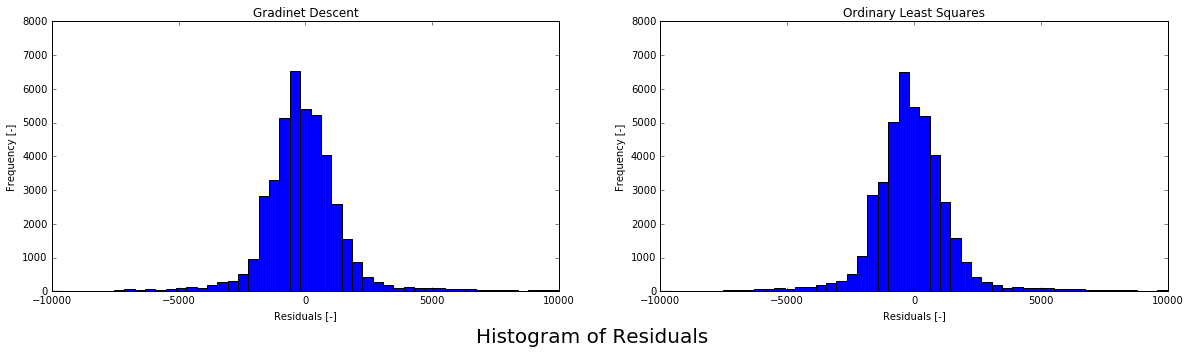

In [7]:
def poltResidual(ax, data, prediction):
    bins = np.linspace(-10000,10000,50)
    ax.hist(data - prediction, bins=bins)
    ax.axis([-10000, 10000, 0, 8000])
    ax.set_xlabel('Residuals [-]')
    ax.set_ylabel('Frequency [-]')

fig = plt.figure(num=None, figsize=(20, 5), dpi = 80)
gs = gc.GridSpec(1,2)
gs.update(hspace = 0, bottom = 0.15)
ax1 = fig.add_subplot(gs[0])
poltResidual(ax1, data, predict_sk)
ax1.set_title('Gradinet Descent')
ax2 = fig.add_subplot(gs[1])
poltResidual(ax2, data, predict_sm)
ax2.set_title('Ordinary Least Squares')
fig.text(0.5, 0.01, "Histogram of Residuals", ha = "center", fontsize=20)
plt.show()

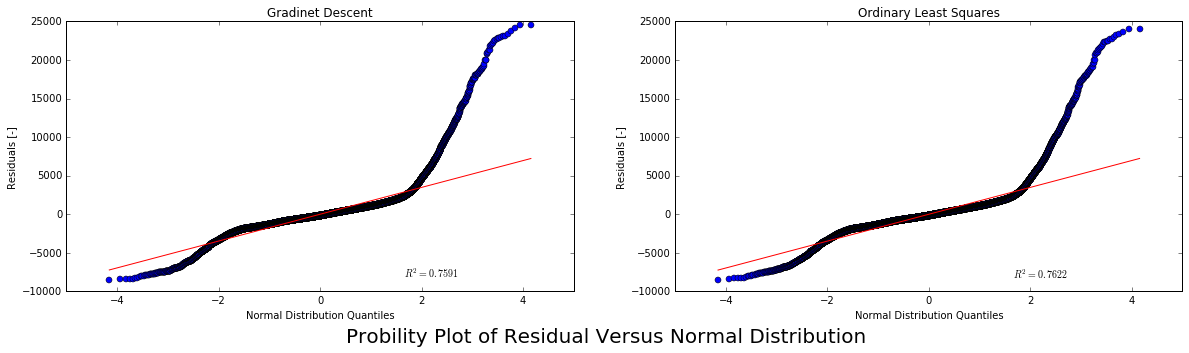

In [8]:
def poltProResidual(ax, data, prediction):
    st.probplot(data - prediction, plot=ax)
    ax.set_xlabel("Normal Distribution Quantiles")
    ax.set_ylabel("Residuals [-]")
    
fig = plt.figure(num=None, figsize=(20, 5), dpi = 80)
gs = gc.GridSpec(1,2)
gs.update(hspace = 0, bottom = 0.15)
ax1 = fig.add_subplot(gs[0])
poltProResidual(ax1, data, predict_sk)
ax1.set_title('Gradinet Descent')
ax2 = fig.add_subplot(gs[1])
poltProResidual(ax2, data, predict_sm)
ax2.set_title('Ordinary Least Squares')
fig.text(0.5, 0.01, "Probility Plot of Residual Versus Normal Distribution", ha = "center", fontsize=20)
plt.show()

<h2>Section 3. Visualization</h2>

<h4>
1. Histogram of ENTRIESn_hourly verse rany days and non rainy days.
</h4>

In [ ]:
def plotHistRain(dF):
    plt.figure()
    nRain = dF['ENTRIESn_hourly'][dF['rain'] == 0].values #not raining
    yRain = dF['ENTRIESn_hourly'][dF['rain'] == 1].values #raining

    plt.hist(nRain, bins=100, color='g', label='non rainy days')
    plt.hist(yRain, bins=100, color='b', label='rainy days')
    plt.legend(loc='upper right')
    plt.axis([0, 8000, 0, 10000])
    plt.title('Histogram of ENTRIESn_hourly')
    plt.xlabel('ENTRIESn_hourly [-]')
    plt.ylabel('Frequency [-]')
    plt.show()

plotHistRain(dF)

<p>
From this histogram, it was obviously that the sample size of non rainy days was much larger than that of rainy days. Besides, both distributions were not normal distribution. Thus, as what I mentioned in section 1, that Mann-Whitney U test was applicable to this statistic test.
</p>

<h4>
2. BarChat of average entries verse week days and hours.
</h4>

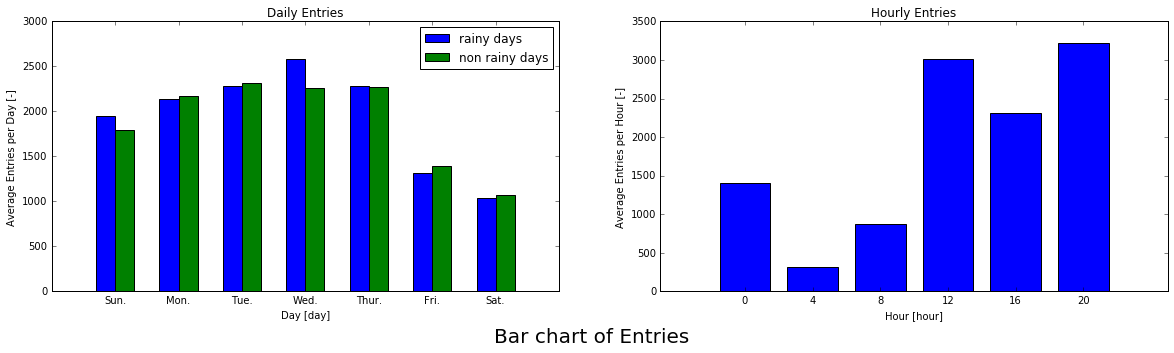

In [62]:

def plotBarDayWeek(dF, ax):
    entries_rainy = []
    entries_nonrainy = []
    days = np.arange(7)
    for day in days:
        rainy_day = np.mean(dF['ENTRIESn_hourly'][dF['day_week'] == day][dF['rain'] == 1])
        nonrainy_day = np.mean(dF['ENTRIESn_hourly'][dF['day_week'] == day][dF['rain'] == 0])
        entries_rainy.append(rainy_day)
        entries_nonrainy.append(nonrainy_day)
        
    daysLabel = ['Sun.', 'Mon.', 'Tue.', 'Wed.', 'Thur.', 'Fri.', 'Sat.']
    ax.bar(days - 0.15, entries_rainy, color='b', align='center', label='rainy days', width = 0.3)
    ax.bar(days + 0.15, entries_nonrainy, color='g', align='center', label='non rainy days', width = 0.3)
    ax.set_title('Daily Entries')
    ax.legend(loc='upper right')
    ax.set_xticks(days)
    ax.set_xticklabels(daysLabel)
    ax.set_xlabel('Day [day]')
    ax.set_ylabel('Average Entries per Day [-]')

def plotBarHourly(dF, ax):
    entries = []
    hours = range(0, 24, 4)
    for hour in hours:
        entry_hourly = np.mean(dF['ENTRIESn_hourly'][dF['hour'] == hour])
        entries.append(entry_hourly)
    ax.bar(hours, entries, align='center', width=3)
    ax.set_title('Hourly Entries')
    ax.set_xlabel('Hour [hour]')
    ax.set_xticks(hours)
    ax.set_ylabel('Average Entries per Hour [-]')
    
fig = plt.figure(num=None, figsize=(20, 5), dpi = 80)
gs = gc.GridSpec(1,2)
gs.update(hspace = 0, bottom = 0.15)
ax1 = fig.add_subplot(gs[0])
plotBarDayWeek(dF, ax1)
ax2 = fig.add_subplot(gs[1])
plotBarHourly(dF, ax2)
fig.text(0.5, 0.01, "Bar chart of Entries", ha = "center", fontsize=20)
plt.show()

<p>
Actually, I got really low R<sup>2</sup> when I used 'rain' as feature only to do the linear regression. It was about 0.0006. Of course, 'UNIT' did affect the results very much. However, I found out that hours and days as the features did affect the results of linear regression. Fisrt, I wanted to take a look at the distribution of entries in different days. According to the figure above, it was obvious that people take the subway from Sunday to Thursday more. It might be the reason that the R<sup>2</sup> was getting higher when I added days as the feature. But there was one thing attracted my attention, that was there actually was not big different in rideship between rainy days and non rainy days. It might indicated that people in New York don't care about it is rainy or not when they are going to take tain. I understand it is very dangerous to jump to the conclusion by this bar chat, because the sample sizes were quite different and this chart only could tell the different in entries among the days. Second, I take a look at the distribution of entries per average hour a day. It is obviously that people take the subway during 12:00 to 20:00.  The file provided entries data at 0, 4, 8, 12, 16 and 20 o'clock. So it made sense that it is rush time that people go to work from 9 to 12 o'clock and then go home from 17 to 20 o'clock. Besides, it is about 56 million foreign and American tourists in New York city. I think it is reasonable to assume that tourists take the subway during daytime. In my opinion, it strongly affeted the results of linear regression.
</p>

<h2>Section 4. Conclusion</h2>

<h4>
4.1 From your analysis and interpretation of the data, do more people ride the NYC subway when it is raining or when it is not raining?  
</h4>

<p>
According to the result of the analysis, more people ride the NYC subway when it is raining.
</p>

<h4>
4.2 What analyses lead you to this conclusion? You should use results from both your statistical
tests and your linear regression to support your analysis.
</h4>

The result of Mann-Whitney U Test told that the increase in ridership on rainy days was statistically significant with 95% confidence, because statistic U was positive and the calculated p-value, 5.48&#215;10<sup>-6</sup>, was much less then critical p-value, 0.05. Besides, the positive coefficient for the 'rain' parameter calculated by both methods  indicated that people ride the NYC subway more when it is raining. According to the analysis of R<sup>2</sup> showed that not all the cases agree this conclusion, the small residuals show relatively high accuracy and R<sup>2</sup> which was 0.54 was an accpetable value for a noisy data, given our objectives.

<h2>Section 5. Reflection</h2>

<h4>
5.1 Please discuss potential shortcomings of the methods of your analysis, including:<br>
Dataset,<br>
Analysis, such as the linear regression model or statistical test.
</h4>

<p>
First of all, the number of the data set was not enough or even quite small. This dataset only provided the data in May 2011. The results might indicate the particular case in 2011. And it is reasonable that the temperature and the precipitation are quite different in different seasons. Thus, they may become very important feature to affect the ridership of the NYC subway, especially they are highly relative to that it is raining or not. Thus, it was hard of the results to represent general case. 
</p>
<p>
Second, over 56 million foreign and American tourists including day trippers each year in New City. So, what proportion of the riders were tourists, day trippers and recreational riders. This information is quite important. It is very convenient of the tourists to take the subway no matter it is raining or not. For the day trippers and recreational rider, they may stay indoor when it is raining. Besides, it is also reasonable to consider the factors that what proportion of the riders have alternative methods to transport. Are these methods to transport available in a rainy day? In my opinion, these kinds of the information are really helpful to provide a more reliable results to do the predictions.  
</p>
<p>
Last, the histogram of residual and the probility plot of residuals versus normal distribution suggested that the models procedured extremely inaccurent results in some cases, especially in large value of the residuals. Actually, I have tuned eta0, the initial learning rate, of Gradient Descent method to procedure the results better. However, the results of both methods were similar. It might be the limitation in linear model. Besides, Threre were very large number of the dummy variable when 'UNIT' was selected as the feature. It was really helpful to imporve the results. Honestly, I am still confused why this feature was selected in the course of Intro to Data Science. Is it just because it could improve the results very well? On the other hand, the results changed very slightly with combinations of weather data. It did make me confused to select the appropriate features to do the analysis.   
</p>